In [1]:
#/kaggle/input/Kannada-MNIST/Dig-MNIST.csv - validation
#/kaggle/input/Kannada-MNIST/train.csv     - training
#/kaggle/input/Kannada-MNIST/test.csv      - test
#/kaggle/input/Kannada-MNIST/sample_submission.csv

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

MAX_VALUE = 255

# Helper Functions

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def imgPlotter(x=None, idx=None, name=None):
    img = x.copy()
    img = img.reshape(28, 28)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("{name}_Sample_{idx}".format(name=name, idx=idx))
    plt.show()

# Data Handling

**Inputs**

In [4]:
tr_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
ts_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
va_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

breaker()
print("Train Set Shape :", repr(tr_Set.shape))
breaker()
print("Test Set Shape  :", repr(ts_Set.shape))
breaker()
print("Valid Set Shape :", repr(va_Set.shape))
breaker()

X_train, y_train = tr_Set.iloc[:, 1:].copy().values, tr_Set.iloc[:, 0].copy().values

X_valid, y_valid = va_Set.iloc[:, 1:].copy().values, va_Set.iloc[:, 0].copy().values

X_test  = ts_Set.iloc[:, 1:].copy().values

del tr_Set, ts_Set, va_Set


------------------------------

Train Set Shape : (60000, 785)

------------------------------

Test Set Shape  : (5000, 785)

------------------------------

Valid Set Shape : (10240, 785)

------------------------------



**Normalizing Pixel Values**

In [5]:
X_train = np.divide(X_train, MAX_VALUE)
X_valid = np.divide(X_valid, MAX_VALUE)
X_test  = np.divide(X_test, MAX_VALUE)

num_features = X_train.shape[1]
num_obs_test = X_test.shape[0]

n_size = np.sqrt(num_features).astype(int)
X_train = X_train.reshape(-1, n_size, n_size)
X_valid = X_valid.reshape(-1, n_size, n_size)

**Dataset Template**

In [6]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [7]:
class ANN_CFG():
    tr_batch_size = 128
    va_batch_size = 128
    ts_batch_size = 128
    
    epochs = 20
    
    HL = [2048, 2048]
    OL = 10
    
    n_folds = 4
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
cfg = ANN_CFG()

**Setup**

In [8]:
class CNN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(CNN, this).__init__()
        
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        this.MP  = nn.MaxPool2d(kernel_size=2)
        
        this.BN1 = nn.BatchNorm2d(1)
        this.CN1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        
        this.BN2 = nn.BatchNorm2d(64)
        this.CN2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        
        this.FC1 = WN(nn.Linear(128*5*5, HL[0]))
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        this.FC3 = WN(nn.Linear(HL[1], OL))
        
    def getOptimizer(this):
        return optim.Adam(this.parameters(), lr=1e-3, weight_decay=0)
    
    def forward(this, x):
        x = this.BN1(x)
        x = this.CN1(x)
        x = this.DP1(x)
        x = F.relu(this.MP(x))
        x = this.BN2(x)
        x = this.CN2(x)
        x = this.DP1(x)
        x = F.relu(this.MP(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(this.FC1(x))
        x = this.DP2(x)
        x = F.relu(this.FC2(x))
        x = this.DP2(x)
        x = F.log_softmax(this.FC3(x), dim=1)
        return x

breaker()
print("Train Batch Size :", repr(cfg.tr_batch_size))
print("Valid Batch Size :", repr(cfg.tr_batch_size))
print("Test Batch Size  :", repr(cfg.ts_batch_size))
print("Epochs           :", repr(cfg.epochs))
print("Device Used      :", repr(cfg.device))
breaker()


------------------------------

Train Batch Size : 128
Valid Batch Size : 128
Test Batch Size  : 128
Epochs           : 20
Device Used      : device(type='cuda', index=0)

------------------------------



**ANN Helpers**

In [9]:
def train_fn(X=None, y=None, n_folds=None):
    breaker()
    print("Training ...")
    breaker()
    
    LP = []
    names = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    fold = 0
    
    start_time = time()
    for tr_idx, va_idx in StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold} ...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                       "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=True)
                      }
        
        torch.manual_seed(0)
        model = CNN(None, cfg.HL, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feat, label in dataloaders[phase]:
                    feat, label = feat.to(cfg.device).view(feat.shape[0], 1, n_size, n_size), label.to(cfg.device).view(-1)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feat)
                        loss   = nn.NLLLoss()(output, label)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass = (loss.item()/label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_Fold_{fold}.pt".format(fold=fold)
                names.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {fold} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, fold=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()
    print("Training Complete")
    breaker()
    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None):
    y_pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        model.load_state_dict(torch.load(name))
        model.eval()
        for feat in dataloader:
            feat = feat.to(cfg.device).view(feat.shape[0], 1, n_size, n_size)
            with torch.no_grad():
                logProb = model(feat)
            Prob = torch.exp(logProb)
            Preds = torch.argmax(Prob, dim=1)
            Pred = torch.cat((Pred, Preds.view(-1,1)), dim=0)
        Pred = Pred[cfg.ts_batch_size:].cpu().numpy()
        y_pred = np.add(y_pred, Pred)
    y_pred = np.divide(y_pred, len(names))
    return y_pred.astype(int)


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time Taken to Train 4 folds for 20 epochs : 7.22 minutes

------------------------------

Best Loss : {'train': 2.6785133134884138e-05, 'valid': 4.2094404761883197e-07}

------------------------------

Training Complete

------------------------------



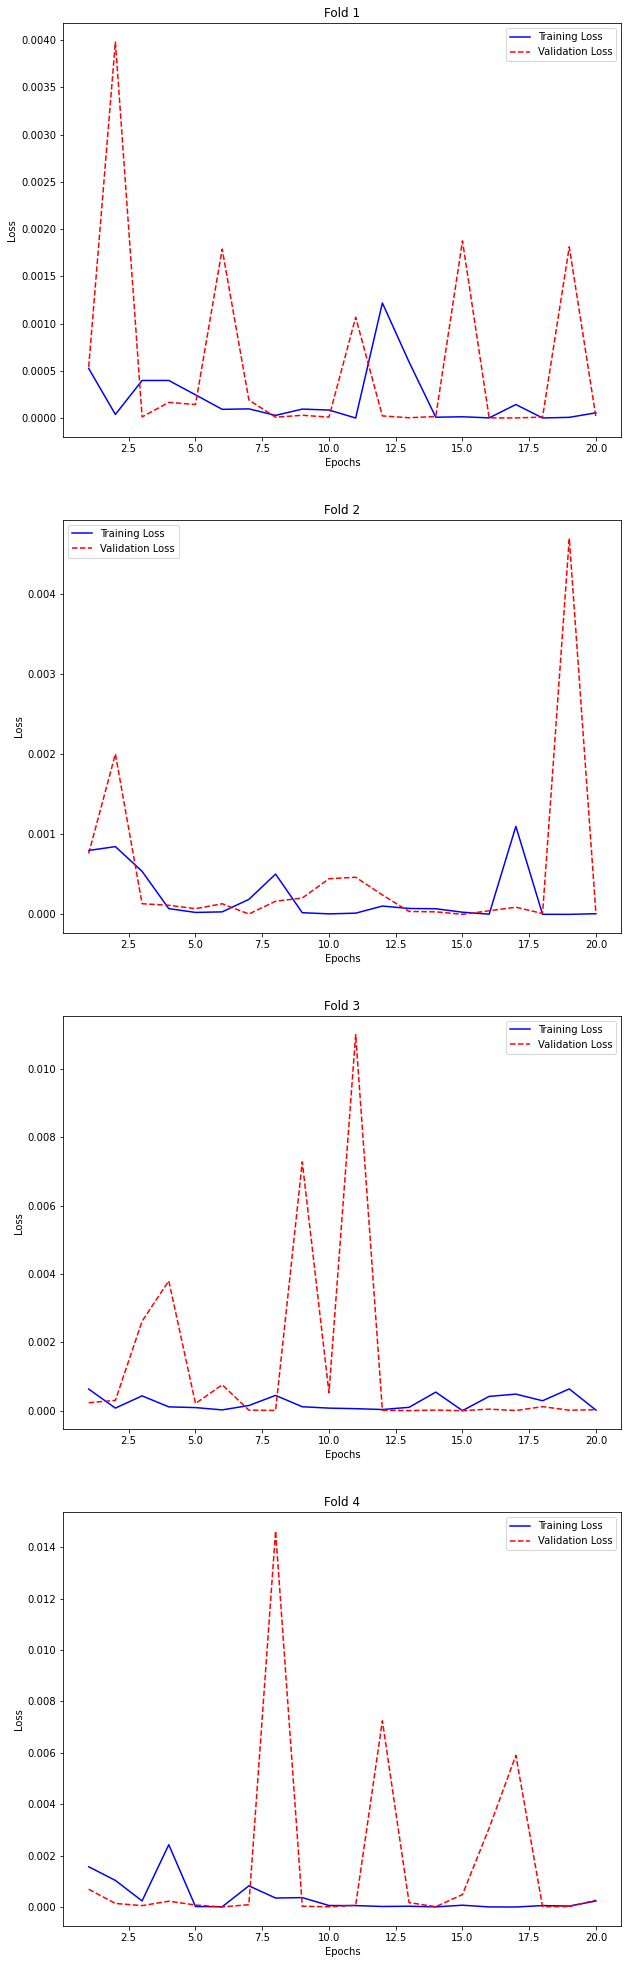

In [10]:
LP, Names, Network = train_fn(X=X_train, y=y_train, n_folds=cfg.n_folds)

LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(10, 35))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

In [11]:
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

ss = pd.read_csv("/kaggle/input/Kannada-MNIST/sample_submission.csv")
ss["label"] = y_pred
ss.to_csv("./submission.csv", index=False)